<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/10.attention_mechanisms/10_7_transformer_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import torch
from torch import nn
import torch
from torch import nn
from torch.nn import functional as F
import collections
import re
import hashlib
import os
import tarfile
import zipfile
import requests
import matplotlib.pyplot as plt
import random
import torch
from torch.nn import functional as F
from torch import nn
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data

In [ ]:
class PositionalEncoding(nn.Module):

  def __init__(self, num_hiddens, dropout, max_len=1000):
    
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(dropout)
    self.P = torch.zeros((1, max_len, num_hiddens))
    X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
    self.P[:, :, 0::2] = torch.sin(X)
    self.P[:, :, 1::2] = torch.cos(X)

  def forward(self, X):

    X = X + self.P[:, :X.shape[1], :].to(X.device)
    return self.dropout(X)

In [ ]:
class PositionWiseFFN(nn.Module):

  def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):

    super(PositionWiseFFN, self).__init__(**kwargs)
    self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
    self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
    self.relu = nn.ReLU()

  def forward(self, X):

    return self.dense2(self.relu(self.dense1(X)))

In [ ]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()

o = ffn(torch.ones((2, 3, 4)))
o.shape

torch.Size([2, 3, 8])

In [ ]:
class AddNorm(nn.Module):

  def __init__(self, normalized_shape, dropout, **kwargs):
    
    super(AddNorm, self).__init__(**kwargs)
    self.dropout = nn.Dropout(dropout)
    self.ln = nn.LayerNorm(normalized_shape)
  
  def forward(self, X, Y):

    return self.ln(self.dropout(Y) + X)

In [ ]:
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)

print(embedding.shape)
layer_norm = nn.LayerNorm(embedding_dim)
print(layer_norm(embedding).shape)

torch.Size([20, 5, 10])
torch.Size([20, 5, 10])


In [ ]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()

add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [ ]:
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4)))

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], grad_fn=<NativeLayerNormBackward0>)

In [ ]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Set `transpose_b=True` to swap the last two dimensions of `keys`
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [ ]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [ ]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [ ]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of `queries`, `keys`, or `values`:
        # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`)
        # Shape of `valid_lens`:
        # (`batch_size`,) or (`batch_size`, no. of queries)
        # After transposing, shape of output `queries`, `keys`, or `values`:
        # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
        # `num_hiddens` / `num_heads`)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for
            # `num_heads` times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of `output`: (`batch_size` * `num_heads`, no. of queries,
        # `num_hiddens` / `num_heads`)
        output = self.attention(queries, keys, values, valid_lens)

        # Shape of `output_concat`:
        # (`batch_size`, no. of queries, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [ ]:
def transpose_qkv(X, num_heads):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`).
    # Shape of output `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_heads`,
    # `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # Shape of output `X`:
    # (`batch_size`, `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # Shape of `output`:
    # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """Reverse the operation of `transpose_qkv`."""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [ ]:
class EncoderBlock(nn.Module):

  def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
    
    super(EncoderBlock, self).__init__(**kwargs)
    self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias)
    self.addnorm1 = AddNorm(norm_shape, dropout)
    self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
    self.addnorm2 = AddNorm(norm_shape, dropout)

  def forward(self, X, valid_lens):

    Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
    return self.addnorm2(Y, self.ffn(Y))

In [ ]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])

encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()

encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [ ]:
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

class TransformerEncoder(Encoder):

  def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
    super(TransformerEncoder, self).__init__(**kwargs)
    self.num_hiddens = num_hiddens
    self.embedding = nn.Embedding(vocab_size, num_hiddens)
    self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
    self.blks = nn.Sequential()
    for i in range(num_layers):
      self.blks.add_module("block"+str(i), EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias))
  
  def forward(self, X, valid_lens, *args):

    X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
    for i, blk in enumerate(self.blks):
      X = blk(X, valid_lens)
      print('Encoder - layer: ', i, ' shape: ', X.shape)
    return X    

In [ ]:
class DecoderBlock(nn.Module):

  def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
    super(DecoderBlock, self).__init__(**kwargs)
    self.i = i
    self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
    self.addnorm1 = AddNorm(norm_shape, dropout)
    self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
    self.addnorm2 = AddNorm(norm_shape, dropout)
    self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
    self.addnorm3 = AddNorm(norm_shape, dropout)

  def forward(self, X, state):

    enc_outputs, enc_valid_lens = state[0], state[1]
    if state[2][self.i] is None:
      key_values = X
    else:
      key_values = torch.cat((state[2][self.i], X), axis=1)
      print('Hello')

    state[2][self.i] = key_values

    if self.training:
      batch_size, num_steps, _ = X.shape
      dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
    else:
      dec_valid_lens = None

    X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
    Y = self.addnorm1(X, X2)
    Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
    Z = self.addnorm2(Y, Y2)
    return self.addnorm3(Z, self.ffn(Z)), state

In [ ]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]

decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [ ]:
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

class AttentionDecoder(Decoder):
    """The base attention-based decoder interface."""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

In [ ]:
class TransformerDecoder(AttentionDecoder):

  def __init__(self, vocab_size, key_size, query_size, value_size,
               num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, 
               num_heads, num_layers, dropout, **kwargs):
    
    super(TransformerDecoder, self).__init__(**kwargs)
    self.num_hiddens = num_hiddens
    self.num_layers = num_layers
    self.embedding = nn.Embedding(vocab_size, num_hiddens)
    self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
    self.blks = nn.Sequential()
    for i in range(num_layers):
      self.blks.add_module("block"+str(i), DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape,
                                                        ffn_num_input, ffn_num_hiddens, num_heads, dropout, i))
    self.dense = nn.Linear(num_hiddens, vocab_size)

  def init_state(self, enc_outputs, enc_valid_lens, *args):

    return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

  def forward(self, X, state):

    X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
    for i, blk in enumerate(self.blks):
      X, state = blk(X, state)
      print('Decoder - layer: ', i, ' shape: ', X.shape)
    return self.dense(X), state

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def tokenize(lines, token='word'):

  if token == 'word':
    return [line.split() for line in lines]
  elif token == 'char':
    return [list(line) for line in lines]
  else:
    print('ERROR: unknow token type: ' + token)

def count_corpus(tokens):

  if len(tokens) == 0 or isinstance(tokens[0], list):
   tokens = [token for line in tokens for token in line]
  return collections.Counter(tokens)

class Vocab:

  def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):

    if tokens is None:
      tokens = []
    if reserved_tokens is None:
      reserved_tokens = []
    counter = count_corpus(tokens)

    self._token_freqs = sorted(counter.items(), key = lambda x: x[1], reverse=True)
    self.idx_to_token = ['<unk>'] + reserved_tokens
    self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
    for token, freq in self._token_freqs:
      if freq < min_freq:
        break;
      if token not in self.token_to_idx:
        self.idx_to_token.append(token)
        self.token_to_idx[token] = len(self.idx_to_token) - 1
  
  def __len__(self):
    return len(self.idx_to_token)
  
  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    else:
      return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if not isinstance(indices, (list, tuple)):
      return self.idx_to_token[indices]
    else:
      return [self.to_tokens(idx) for idx in indices]

  @property
  def unk(self):
    return 0

  @property
  def token_freqs(self):
    return self._token_freqs

def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))

def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

DATA_HUB['time_machine'] = (DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')
DATA_HUB['fra-eng'] = (DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

def tokenize_nmt(text, num_examples=None):

  source, target = [], []
  for i,line in enumerate(text.split('\n')):
    if num_examples and i > num_examples:
      break;
    parts = line.split('\t')
    if len(parts) == 2:
      source.append(parts[0].split(' '))
      target.append(parts[1].split(' '))

  return source, target

class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [ ]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):

  def forward(self, pred, label, valid_len):
    weights = torch.ones_like(label)
    weights = sequence_mask(weights, valid_len)
    unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
    weighted_loss = (unweighted_loss * weights)
    return unweighted_loss

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):

  def xavier_init_weights(m):
    if type(m) == nn.Linear:
      nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.GRU:
      for param in m._flat_weights_names:
        if "weight" in param:
          nn.init.xavier_uniform_(m._parameters[param])
    
  net.apply(xavier_init_weights)
  net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  loss = MaskedSoftmaxCELoss()
  net.train()

  ui_x = []
  ui_y = []
  for epoch in range(num_epochs):
    timer = Timer()
    metric = Accumulator(2)
    for batch in data_iter:

      optimizer.zero_grad()
      X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
      bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                              device=device).reshape(-1, 1)
      dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
      Y_hat, _ = net(X, dec_input, X_valid_len)
      l = loss(Y_hat, Y, Y_valid_len)
      l.sum().backward()
      grad_clipping(net, 1)
      num_tokens = Y_valid_len.sum()
      optimizer.step()
      with torch.no_grad():
        metric.add(l.sum(), num_tokens)
    if (epoch + 1) % 10 == 0:
        ui_x.append(epoch + 1)
        ui_y.append(metric[0] / metric[1])

  plt.plot(ui_x, ui_y, 'r')
  plt.show()
  print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} ' f'tokens/sec on {str(device)}')

In [ ]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
norm_shape = [32]

key_size, query_size, value_size = 32, 32, 32
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

In [ ]:
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

net = EncoderDecoder(encoder, decoder)

In [ ]:
for batch in train_iter:

  X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
  print('X shape: ', X.shape)
  print('Y shape: ', Y.shape)

  bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                              device=device).reshape(-1, 1)
  dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
  
  Y_hat, _ = net(X, dec_input, X_valid_len)
  print('Y_hat shape: ', Y_hat.shape)
  break


X shape:  torch.Size([64, 10])
Y shape:  torch.Size([64, 10])
Encoder - layer:  0  shape:  torch.Size([64, 10, 32])
Encoder - layer:  1  shape:  torch.Size([64, 10, 32])
Decoder - layer:  0  shape:  torch.Size([64, 10, 32])
Decoder - layer:  1  shape:  torch.Size([64, 10, 32])
Y_hat shape:  torch.Size([64, 10, 201])


Streaming output truncated to the last 5000 lines.
Encoder - layer:  0  shape:  torch.Size([64, 10, 32])
Encoder - layer:  1  shape:  torch.Size([64, 10, 32])
Decoder - layer:  0  shape:  torch.Size([64, 10, 32])
Decoder - layer:  1  shape:  torch.Size([64, 10, 32])
Encoder - layer:  0  shape:  torch.Size([64, 10, 32])
Encoder - layer:  1  shape:  torch.Size([64, 10, 32])
Decoder - layer:  0  shape:  torch.Size([64, 10, 32])
Decoder - layer:  1  shape:  torch.Size([64, 10, 32])
Encoder - layer:  0  shape:  torch.Size([64, 10, 32])
Encoder - layer:  1  shape:  torch.Size([64, 10, 32])
Decoder - layer:  0  shape:  torch.Size([64, 10, 32])
Decoder - layer:  1  shape:  torch.Size([64, 10, 32])
Encoder - layer:  0  shape:  torch.Size([64, 10, 32])
Encoder - layer:  1  shape:  torch.Size([64, 10, 32])
Decoder - layer:  0  shape:  torch.Size([64, 10, 32])
Decoder - layer:  1  shape:  torch.Size([64, 10, 32])
Encoder - layer:  0  shape:  torch.Size([64, 10, 32])
Encoder - layer:  1  shape:  to

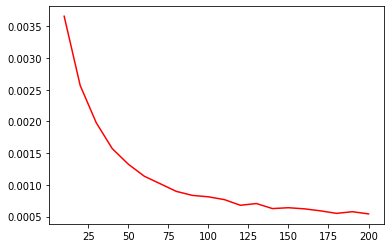

loss 0.001, 3471.1 tokens/sec on cpu


In [ ]:
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)